<a href="https://colab.research.google.com/github/ReVuz/Machine_Learning/blob/main/BlackJack_Using_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction to BlackJack

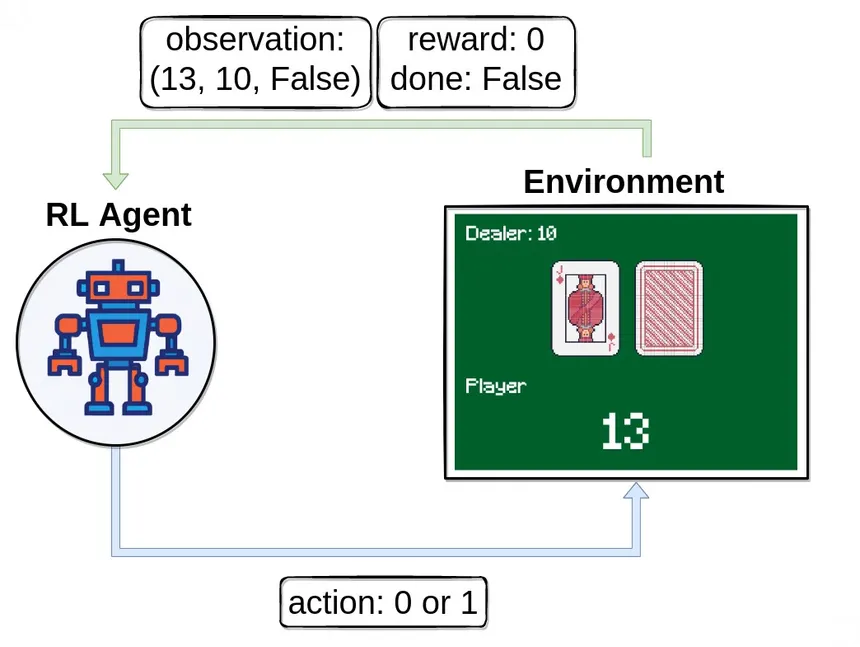

Basic Rules of BlackJack :

1. Game is played with one or more decks of standard playing cards.

2. Each player is dealt 2 cards, and the dealer is also dealt 2 cards, with 1 card faced down.

3. The value of each card is determined by it's rank. Aces can be worth of 1 or 11, face cards (king, queen and jack) are worth 10 and all other cards are worth their value.

4. Players have the option to "Hit" and take additional cards to improve their hand or "Stand" and keep their current hand.

5. The dealer must hit until their hand has a value of 17 or more.

6. If a player's hand goes over 21, they "bust" and lose the game.

7. If the dealer's hand goes over 21, the player wins the game.

8. If neither the player or the dealer busts, the hand with the highest total value that is less than or equal to 21 wins the game.

In [ ]:
import numpy as np
import seaborn as sns
from tqdm import tqdm  #progress bar
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from __future__ import annotations
from collections import deque
from gym.wrappers import RecordEpisodeStatistics

import gymnasium as gym
# print(gym.__version__)

In [ ]:
env = gym.make('Blackjack-v1', sab = True, render_mode = "rgb_array")

In [ ]:
#reset the enviornment
done = False
observation, info = env.reset()
print(observation, info)

(14, 10, 0) {}


Our observation is a tuple of 3 values :

1. player's current sum
2. value in dealer's face-up card
3. Whether we have an ace or not

After receiving our first observation, we are only going to use the ```env.step(action)``` function to interact with the environment. This function takes an action as input and executes it in the environment. Because that action changes the state of the environment, it returns 4 variables. These are :

- ```next_state``` : The observation that the agent will receive after taking the action

- ```reward``` : Reward that the agent will receive after taking the action

- ```terminated``` : Boolean variable which determines whether the environment has terminated or not

- ```truncated``` : A boolean variable which also determines whether the episode ended by early truncation; i.e, Time limit reached

- ```info``` : Dictionary which might contain the additional information about the environment. For example in the Atari environments, the info dictionary has `ale-lives` key which tells us how many lives the agent has left. If the agent has 0 lives, then the episode is over.


In [ ]:
#sample action from all valid actions
action = env.action_space.sample()
#action = 1

#Execute the action
observation, reward, terminated, truncated,info = env.step(action)
print(observation, reward, terminated, truncated, info)

(18, 10, 0) 0.0 False False {}


If terminated = True, then stop the current episode and begin a new one using ```env.rest()```.

Epsilon Greedy Strategy to Solve BlackJack

1. The agent takes an ation that is either the best action based on the current policy (probability of ```1 - epsilon``` ) or a random action( probability of ```epsilon```). This approach balances the exploitation of current best policy with the exploration of new policies, which can lead to better rewards in the long run.

2. As the game is played repeatedly, the agent learns the optimal policy that maximizes the expected reward. Initially the agent may explore by taking random actions to discover new strategies. However, as the game progresses, the agent will start to exploit the best-known policy, which should maximize the expected reward over time.

In [ ]:
class BlackjackAgent:
  def __init__(
    self,
    learning_rate:float,
    initial_epsilon:float,
    epsilon_decay:float,
    final_epsilon:float,
    discount_factor:float = 0.95
  ):
   self.q_values = defaultdict(lambda:np.zeros(env.action_space.n))
   self.lr = learning_rate
   self.discount_factor = discount_factor
   self.epsilon = initial_epsilon
   self.epsilon_decay = epsilon_decay
   self.final_epsilon = final_epsilon
   self.training_error = []
  def get_action(self, obs:tuple[int,int,bool])->int:
    if np.random.random()< self.epsilon:
      return env.action_space.sample()
    else:
      return int(np.argmax(self.q_values[obs]))

  def update(self, obs:tuple[int,int,bool],action:int,reward:float,terminated:bool,next_obs:tuple[int,int,bool]):
    future_q_value = (not terminated) * np.max(self.q_values[next_obs])
    temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])

    self.q_values[obs][action] = (self.q_values[obs][action] + self.lr * temporal_difference)
    self.training_error.append(temporal_difference)

  def decay_epsilon(self):
      self.epsilon = max(self.final_epsilon,self.epsilon-self.epsilon_decay)

In [ ]:
learning_rate = 0.01
n_episodes = 100_00
start_epsilon=1.0
epsilon_decay = start_epsilon/(n_episodes/2)  #reduce exploration overtime
final_epsilon = 0.1

agent = BlackjackAgent(learning_rate=learning_rate,initial_epsilon=start_epsilon,epsilon_decay=epsilon_decay,final_epsilon=final_epsilon)

In [ ]:
from IPython.display import clear_output
env = gym.wrappers.RecordEpisodeStatistics(env)
for episode in tqdm(range(n_episodes)):
  obs, info = env.reset()
  done = False
  clear_output()

  #play one episode
  while not done :
    action = agent.get_action(obs)
    next_obs,reward,terminated,truncated,info = env.step(action)
    agent.update(obs,action,reward,terminated,next_obs)
    frame = env.render()
    plt.imshow(frame)
    plt.show()

    done = terminated or truncated
    obs = next_obs

  agent.decay_epsilon()

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols = 3 ,figsize = (12,5))
axs[0].set_title("Episode Rewards")
rolling_length = 500
fig, axs = plt.subplots(nrows = 3, figsize = (12,5))
axs[0].set_title("Episode Rewards")
reward_moving_average=(np.convolve(
                      np.array(env.return_queue).flatten(), np.ones(rolling_length),mode = "valid")/rolling_length)
axs[0].plot(range(len(reward_moving_average)),reward_moving_average)
axs[1].set_title("Episode Length")
training_error_moving_average = (np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length),mode = "same")/rolling_length)
axs[2].plot(range(len(training_error_moving_average)),training_error_moving_average)
plt.tight_layout()
plt.show()